<a href="https://colab.research.google.com/github/CalculatedContent/WW_PGD/blob/main/examples/WW_PGD_Muon_MLP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ======================================================
# GOOGLE COLAB CELL: FashionMNIST 3-layer MLP
# Runs (3 seeds each, 10 epochs):
#   (1) AdamW
#   (2) REAL Muon (torch.optim.Muon) + AdamW for biases/1D params
#   (3) Muon + ww_pgd (etas SMALL)
#   (4) Muon + ww_pgd (etas = 0.5)  [stress test]
#
# Logs per epoch:
#   - Train loss + Train acc
#   - Test loss + Test acc
#   - Aug test loss + Aug test acc
#   - WeightWatcher α per layer (FC1/FC2/FC3)
#
# Plots (all with mean ± std error bars):
#   - Train loss (all 4)
#   - Test loss (all 4)
#   - Aug test loss (all 4)
#   - Train acc (all 4)
#   - Test acc (all 4)
#   - Aug test acc (all 4)
#   - α curves: Muon / Muon+wwpgd(small) / Muon+wwpgd(0.5) on SAME plot
# ======================================================

!pip -q install weightwatcher
!pip -q install git+https://github.com/CalculatedContent/WW_PGD.git

import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import weightwatcher as ww
import ww_pgd

# -----------------------------
# Repro + device
# -----------------------------
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
pin_memory = device == "cuda"
num_workers = 2

# -----------------------------
# Global experiment config
# -----------------------------
NUM_EPOCHS = 10
N_RUNS = 3
batch_size = 128

# -----------------------------
# Data: FashionMNIST
# -----------------------------
plain_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Mild in-distribution augmentation for eval (NO flips)
aug_eval_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03)),
    transforms.ColorJitter(brightness=0.2),
    transforms.GaussianBlur(3, sigma=(0.1, 0.3)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.FashionMNIST("./data", train=True, download=True, transform=plain_transform)
test_ds  = datasets.FashionMNIST("./data", train=False, download=True, transform=plain_transform)
test_aug_ds = datasets.FashionMNIST("./data", train=False, download=True, transform=aug_eval_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_aug_loader = DataLoader(test_aug_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

# -----------------------------
# Model: 3-layer MLP
# -----------------------------
class MLP3(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),  # net.1
            nn.ReLU(),
            nn.Linear(512, 512),    # net.3
            nn.ReLU(),
            nn.Linear(512, 10),     # net.5
        )
    def forward(self, x):
        return self.net(x)

# -----------------------------
# Eval helper (loss + acc)
# -----------------------------
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_sum = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction="sum")
        loss_sum += loss.item()
        pred = logits.argmax(dim=-1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return loss_sum / total, correct / total

# -----------------------------
# WeightWatcher alpha extractor (FC1/FC2/FC3)
# -----------------------------
def ww_fc_alphas(model):
    watcher = ww.WeightWatcher(model=model)
    df = watcher.analyze(detX=True, randomize=False, plot=False)
    name_col = "longname" if "longname" in df.columns else ("name" if "name" in df.columns else None)
    if name_col is None or "alpha" not in df.columns:
        return (np.nan, np.nan, np.nan)
    layer_map = {"net.1":"FC1","net.3":"FC2","net.5":"FC3"}
    out = {"FC1":np.nan,"FC2":np.nan,"FC3":np.nan}
    for _, row in df.iterrows():
        lname = str(row[name_col])
        if lname in layer_map:
            a = row.get("alpha", np.nan)
            try: a = float(a)
            except: a = np.nan
            if (not np.isfinite(a)) or (a <= 0) or (a == -1.0):
                a = np.nan
            out[layer_map[lname]] = a
    return (out["FC1"], out["FC2"], out["FC3"])

# ======================================================
# REAL Muon setup: Muon for 2D weights + AdamW for biases/1D params
# plus ww_pgd applied to Muon
# ======================================================
class TwoOpt:
    """
    Minimal wrapper to run two optimizers on disjoint param sets.
    Provides .zero_grad() and .step() like a single optimizer.
    """
    def __init__(self, opt_main, opt_other):
        self.opt_main = opt_main
        self.opt_other = opt_other

    def zero_grad(self, set_to_none=True):
        self.opt_main.zero_grad(set_to_none=set_to_none)
        self.opt_other.zero_grad(set_to_none=set_to_none)

    def step(self):
        self.opt_other.step()
        return self.opt_main.step()

def split_params_for_muon(model):
    """
    Muon is designed for 2D parameters of hidden layers.
    We put 2D tensors in Muon, everything else in AdamW.
    """
    muon_params = []
    other_params = []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 2 and ("weight" in name):
            muon_params.append(p)
        else:
            other_params.append(p)
    return muon_params, other_params

# -----------------------------
# Modes
# -----------------------------
MODES = [
    "adamw",
    "muon",
    "muon+wwpgd_small",
    "muon+wwpgd_05",
]

# -----------------------------
# Optimizer builders (good defaults for FashionMNIST MLP)
# -----------------------------
def make_adamw(model):
    return torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

def make_muon_pair(model, muon_lr=1e-3, muon_wd=0.1):
    muon_params, other_params = split_params_for_muon(model)
    mu = torch.optim.Muon(
        muon_params,
        lr=muon_lr,
        weight_decay=muon_wd,
        momentum=0.95,
        nesterov=True,
        ns_steps=5,
        eps=1e-7,
        adjust_lr_fn="match_rms_adamw",
    )
    other = torch.optim.AdamW(other_params, lr=1e-3, weight_decay=0.01)
    return mu, other

def make_muon_baseline(model):
    mu, other = make_muon_pair(model, muon_lr=1e-3, muon_wd=0.1)
    return TwoOpt(mu, other), None  # opt, ww_opt

def make_muon_wwpgd(model, cayley_eta, blend_eta, warmup=2, ramp=5):
    mu, other = make_muon_pair(model, muon_lr=1e-3, muon_wd=0.1)
    cfg = ww_pgd.WWTailConfig(
        enable_tail_pgd=True,
        min_tail=5,
        q=1.0,
        blend_eta=blend_eta,
        cayley_eta=cayley_eta,
        use_detx=True,
        warmup_epochs=warmup,
        ramp_epochs=ramp,
        enable_trap_pgd=False,
        verbose=False,
    )
    mu_wrapped = ww_pgd.WWPGDWrapper(
        model=model,
        base_optimizer=mu,
        tail_config=cfg,
        apply_every_epochs=1,
        ww_logs=None,
    )
    return TwoOpt(mu_wrapped, other), mu_wrapped  # opt, ww_opt

# -----------------------------
# Train one run
# -----------------------------
def run_one(run_id: int, mode: str, num_epochs: int):
    torch.manual_seed(1000 + run_id)
    np.random.seed(1000 + run_id)

    model = MLP3().to(device)

    if mode == "adamw":
        opt = make_adamw(model)
        ww_opt = None
    elif mode == "muon":
        opt, ww_opt = make_muon_baseline(model)
    elif mode == "muon+wwpgd_small":
        opt, ww_opt = make_muon_wwpgd(model, cayley_eta=0.10, blend_eta=0.10, warmup=2, ramp=5)
    elif mode == "muon+wwpgd_05":
        opt, ww_opt = make_muon_wwpgd(model, cayley_eta=0.50, blend_eta=0.50, warmup=2, ramp=5)
    else:
        raise ValueError("Unknown mode")

    # logs
    tr_loss, tr_acc = [], []
    te_loss, te_acc = [], []
    au_loss, au_acc = [], []
    a1, a2, a3 = [], [], []

    print(f"\n[Run {run_id}] Mode={mode}")

    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0.0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)

            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            bs = yb.size(0)
            loss_sum += loss.item() * bs
            pred = logits.argmax(dim=-1)
            correct += (pred == yb).sum().item()
            total += bs

        # epoch-boundary ww_pgd projection (requires num_epochs)
        if ww_opt is not None:
            ww_opt.apply_tail_projection(epoch=epoch, num_epochs=num_epochs)

        # epoch metrics
        train_loss_epoch = loss_sum / max(1, total)
        train_acc_epoch = correct / max(1, total)

        test_loss_epoch, test_acc_epoch = evaluate(model, test_loader)
        aug_loss_epoch, aug_acc_epoch = evaluate(model, test_aug_loader)

        tr_loss.append(train_loss_epoch); tr_acc.append(train_acc_epoch)
        te_loss.append(test_loss_epoch);  te_acc.append(test_acc_epoch)
        au_loss.append(aug_loss_epoch);   au_acc.append(aug_acc_epoch)

        # ww alphas
        fc1, fc2, fc3 = ww_fc_alphas(model)
        a1.append(fc1); a2.append(fc2); a3.append(fc3)

        print(f"[Run {run_id}][Epoch {epoch+1}/{num_epochs}] "
              f"Train={train_acc_epoch*100:.2f}% (loss={train_loss_epoch:.4f}) | "
              f"Test={test_acc_epoch*100:.2f}% (loss={test_loss_epoch:.4f}) | "
              f"Aug={aug_acc_epoch*100:.2f}% (loss={aug_loss_epoch:.4f}) | "
              f"α: FC1={fc1:.2f} FC2={fc2:.2f} FC3={fc3:.2f}")

    return {
        "train_loss": np.array(tr_loss), "train_acc": np.array(tr_acc),
        "test_loss":  np.array(te_loss), "test_acc":  np.array(te_acc),
        "aug_loss":   np.array(au_loss), "aug_acc":   np.array(au_acc),
        "alpha_FC1":  np.array(a1), "alpha_FC2": np.array(a2), "alpha_FC3": np.array(a3),
    }

# -----------------------------
# Run experiments: 3 runs each
# -----------------------------
results = {m: [] for m in MODES}
for m in MODES:
    print(f"\n=== {m.upper()} ===")
    for r in range(N_RUNS):
        base = {"adamw":0, "muon":100, "muon+wwpgd_small":200, "muon+wwpgd_05":300}[m]
        results[m].append(run_one(run_id=base + r, mode=m, num_epochs=NUM_EPOCHS))

epochs = np.arange(1, NUM_EPOCHS+1)

def stack_metric(mode, key):
    return np.stack([d[key] for d in results[mode]], axis=0)

def mean_std(arr):
    return arr.mean(axis=0), arr.std(axis=0)



  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using device: cuda

=== ADAMW ===

[Run 0] Mode=adamw
SMALL N PL FIT
[Run 0][Epoch 1/10] Train=82.62% (loss=0.4754) | Test=85.83% (loss=0.3882) | Aug=79.51% (loss=0.5561) | α: FC1=2.27 FC2=2.62 FC3=2.71
SMALL N PL FIT
[Run 0][Epoch 2/10] Train=87.43% (loss=0.3383) | Test=86.64% (loss=0.3707) | Aug=80.50% (loss=0.5383) | α: FC1=2.06 FC2=2.39 FC3=2.33
SMALL N PL FIT
[Run 0][Epoch 3/10] Train=88.87% (loss=0.2993) | Test=87.89% (loss=0.3390) | Aug=81.54% (loss=0.5165) | α: FC1=1.97 FC2=2.31 FC3=2.29
SMALL N PL FIT
[Run 0][Epoch 4/10] Train=89.73% (loss=0.2736) | Test=86.21% (loss=0.3742) | Aug=79.82% (loss=0.5508) | α: FC1=1.92 FC2=2.24 FC3=2.22
SMALL N PL FIT
[Run 0][Epoch 5/10] Train=90.16% (loss=0.2566) | Test=88.07% (loss=0.3390) | Aug=81.26% (loss=0.5293) | α: FC1=1.85 FC2=2.18 FC3=2.28
SMALL N PL FIT
[Run 0][Epoch 6/10] Train=90.88% (loss=0.2398) | Te

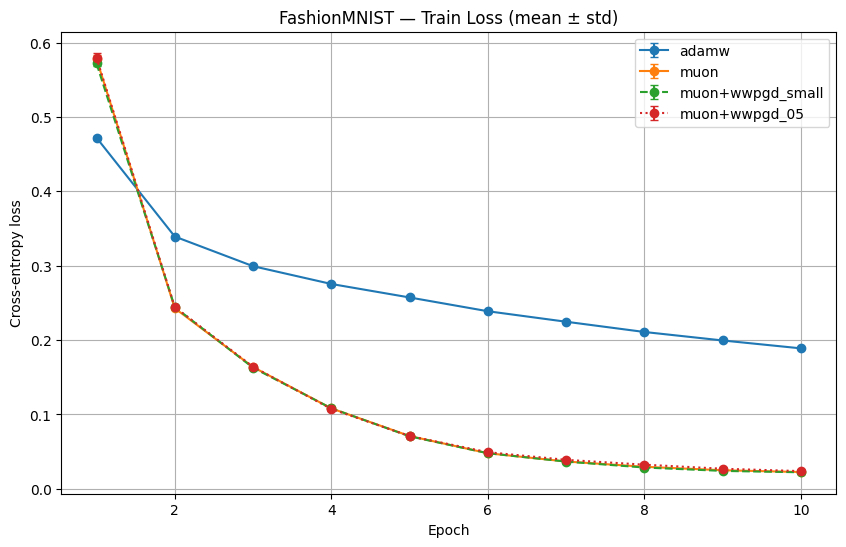

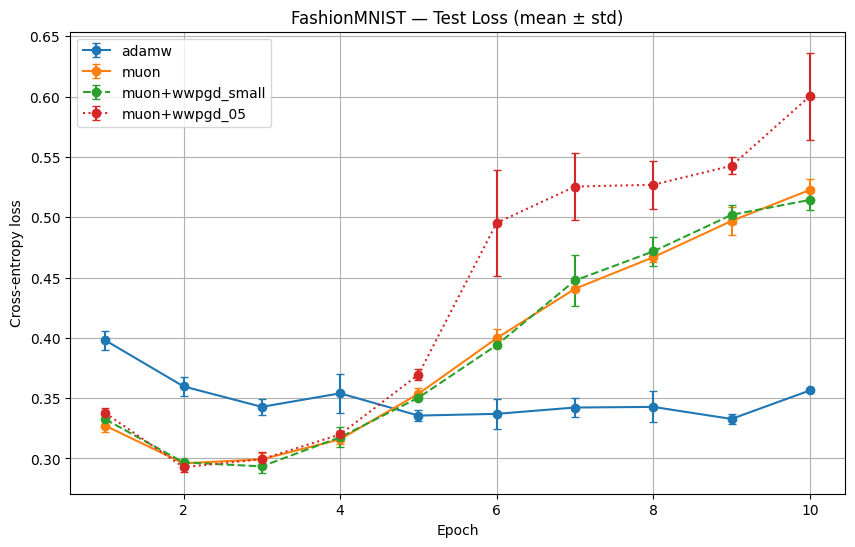

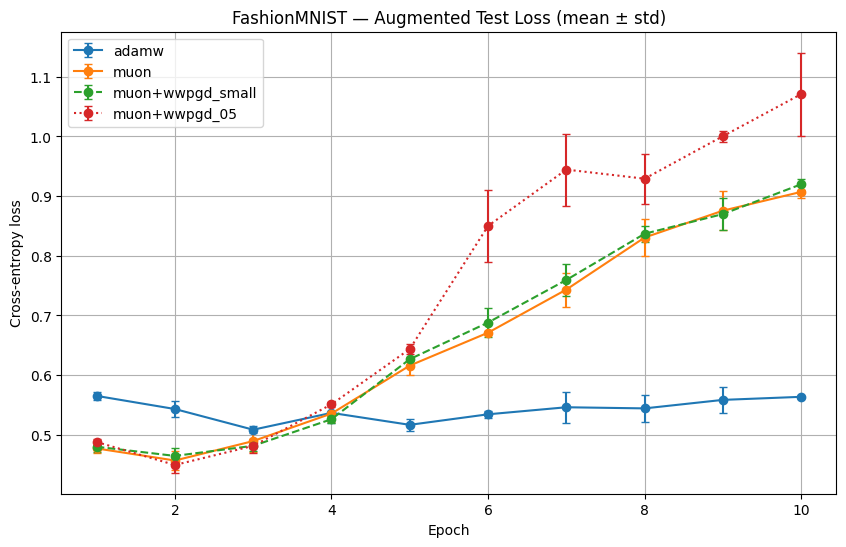

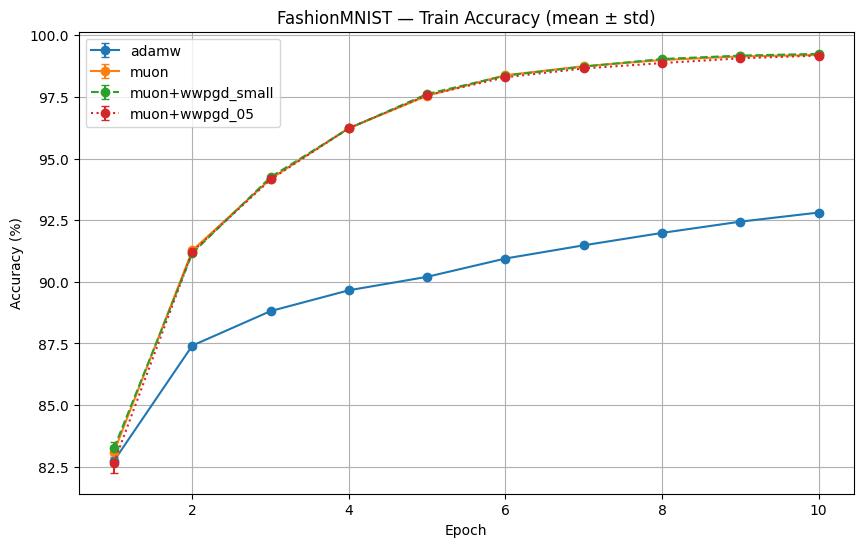

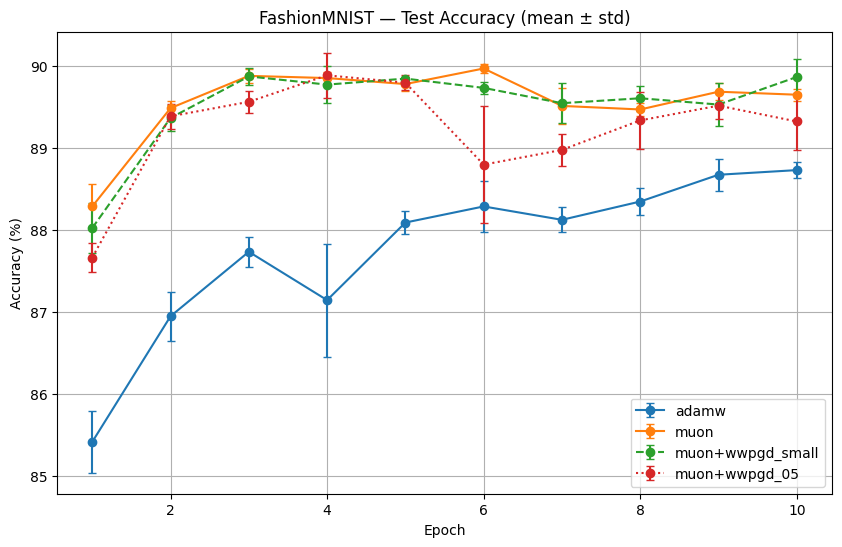

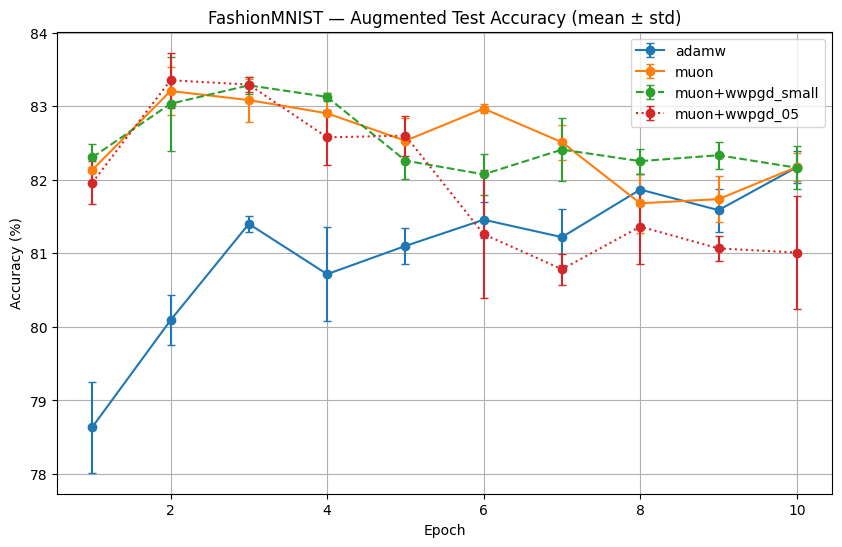


Final (epoch 10) mean ± std:
adamw: plain=88.73% ± 0.10%, aug=82.17% ± 0.22%
muon: plain=89.65% ± 0.07%, aug=82.17% ± 0.18%
muon+wwpgd_small: plain=89.87% ± 0.22%, aug=82.16% ± 0.29%
muon+wwpgd_05: plain=89.33% ± 0.35%, aug=81.01% ± 0.77%


In [15]:
# -----------------------------
# Plot helpers: losses and accuracies (ALL MODES on same plot)
# -----------------------------
def plot_all_modes(key, title, ylabel, is_acc=False):
    plt.figure(figsize=(10,6))
    for m, ls in zip(MODES, ["-", "-", "--", ":"]):
        arr = stack_metric(m, key)
        mu, sd = mean_std(arr)
        if is_acc:
            plt.errorbar(epochs, mu*100, yerr=sd*100, marker="o", linestyle=ls, capsize=3, label=m)
        else:
            plt.errorbar(epochs, mu, yerr=sd, marker="o", linestyle=ls, capsize=3, label=m)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title + " (mean ± std)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_all_modes("train_loss", "FashionMNIST — Train Loss", "Cross-entropy loss", is_acc=False)
plot_all_modes("test_loss",  "FashionMNIST — Test Loss", "Cross-entropy loss", is_acc=False)
plot_all_modes("aug_loss",   "FashionMNIST — Augmented Test Loss", "Cross-entropy loss", is_acc=False)

plot_all_modes("train_acc", "FashionMNIST — Train Accuracy", "Accuracy (%)", is_acc=True)
plot_all_modes("test_acc",  "FashionMNIST — Test Accuracy", "Accuracy (%)", is_acc=True)
plot_all_modes("aug_acc",   "FashionMNIST — Augmented Test Accuracy", "Accuracy (%)", is_acc=True)

# -----------------------------
# Final summary
# -----------------------------
def final_line(mode):
    te = stack_metric(mode, "test_acc"); au = stack_metric(mode, "aug_acc")
    te_m, te_s = te.mean(axis=0)[-1], te.std(axis=0)[-1]
    au_m, au_s = au.mean(axis=0)[-1], au.std(axis=0)[-1]
    return f"{mode}: plain={te_m*100:.2f}% ± {te_s*100:.2f}%, aug={au_m*100:.2f}% ± {au_s*100:.2f}%"

print("\nFinal (epoch {}) mean ± std:".format(NUM_EPOCHS))
for m in MODES:
    print(final_line(m))

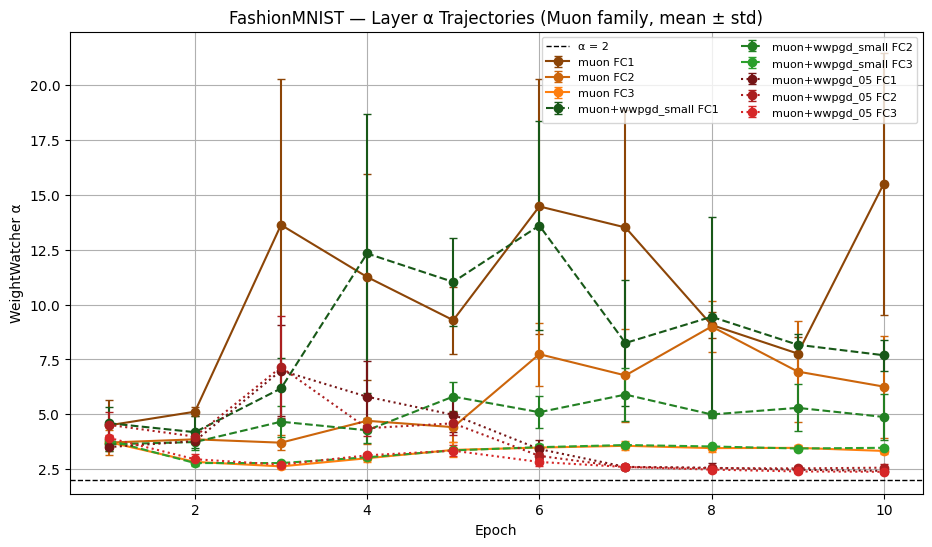

In [16]:

# -----------------------------
# Alpha plots: ONLY MUON family on same plot, gradient colors
# -----------------------------
MUON_FAMILY = ["muon", "muon+wwpgd_small", "muon+wwpgd_05"]
muon_family_styles = {
    "muon": ("-",  "#ff7f0e"),   # orange
    "muon+wwpgd_small": ("--", "#2ca02c"),   # green
    "muon+wwpgd_05": (":",  "#d62728"),   # red
}

layer_grad = {
    "alpha_FC1": 0.55,
    "alpha_FC2": 0.80,
    "alpha_FC3": 1.00,
}

def _shade(hex_color, factor):
    # factor in [0,1] used to darken/lighten; simple RGB scaling
    h = hex_color.lstrip("#")
    r = int(h[0:2], 16); g = int(h[2:4], 16); b = int(h[4:6], 16)
    r = int(r * factor); g = int(g * factor); b = int(b * factor)
    return f"#{r:02x}{g:02x}{b:02x}"

plt.figure(figsize=(11,6))
for mode in MUON_FAMILY:
    ls, base_color = muon_family_styles[mode]
    for key in ["alpha_FC1","alpha_FC2","alpha_FC3"]:
        arr = stack_metric(mode, key)
        mu, sd = mean_std(arr)
        color = _shade(base_color, layer_grad[key])
        plt.errorbar(
            epochs, mu, yerr=sd,
            marker="o", linestyle=ls, capsize=3,
            color=color,
            label=f"{mode} {key[-3:]}"
        )

plt.axhline(2.0, color="black", linestyle="--", linewidth=1, label="α = 2")
plt.xlabel("Epoch")
plt.ylabel("WeightWatcher α")
plt.title("FashionMNIST — Layer α Trajectories (Muon family, mean ± std)")
plt.grid(True)
plt.legend(ncol=2, fontsize=8)
plt.show()